# Fully Connected Neural Network Archtecture

[...]

In [51]:
import math
import pandas as pd
import numpy as np 
import tensorflow as tf
import warnings
import spacy

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Load Data

In [7]:
df_train = pd.read_csv('data/dados_treino.txt', header=None, delimiter=';')
df_test = pd.read_csv('data/dados_teste.txt', header=None, delimiter=';')

df_train = df_train.rename(columns= {0: 'text', 1: 'feeling'})
df_test = df_test.rename(columns= {0: 'text', 1: 'feeling'})

print(df_train.shape)
print(df_test.shape)

(16000, 2)
(2000, 2)


In [8]:
display(df_train.head(3))
display(df_test.head(3))

,text,feeling
0,i am feeling completely overwhelmed i have two strategies that help me to feel grounded pour my heart out in my journal in the form of a letter to god and then end with a list of five things i am most grateful for,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your support and encouragement is a great feeling and i am so glad you were able to help me,joy


,text,feeling
0,i feel like my only role now would be to tear your sails with my pessimism and discontent,sadness
1,i feel just bcoz a fight we get mad to each other n u wanna make a publicity n let the world knows about our fight,anger
2,i feel like reds and purples are just so rich and kind of perfect,joy


> The column **text** is going to be the input feature and **feeling** is going to be the output target.

In [9]:
df_train['feeling'].value_counts()

feeling
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [10]:
df_test['feeling'].value_counts()

feeling
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

## Data preprocessing using Spacy

[Oficial site](https://spacy.io/).

In [11]:
!python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [13]:
# Load the dict
spacy_nlp = spacy.load('en_core_web_md')

In [16]:
def data_preprocessing(text):

    doc = spacy_nlp(text)

    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]

    return ' '.join(tokens)

In [19]:
df_train['transformed_text'] = df_train['text'].apply(data_preprocessing)
df_test['transformed_text'] = df_test['text'].apply(data_preprocessing)

In [20]:
display(df_train.head())
display(df_test.head())

,text,feeling,transformed_text
0,i am feeling completely overwhelmed i have two strategies that help me to feel grounded pour my heart out in my journal in the form of a letter to god and then end with a list of five things i am most grateful for,fear,feel completely overwhelmed strategy help feel ground pour heart journal form letter god end list thing grateful
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your support and encouragement is a great feeling and i am so glad you were able to help me,joy,able help chai lifeline support encouragement great feeling glad able help
3,i already feel like i fucked up though because i dont usually eat at all in the morning,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i can no longer tolerate the effect that bm has on our lives and the fact that is has turned my so into a bitter angry person who is not always particularly kind to the people around him when he is feeling stressed,sadness,love wish good long tolerate effect bm life fact turn bitter angry person particularly kind people feel stress


,text,feeling,transformed_text
0,i feel like my only role now would be to tear your sails with my pessimism and discontent,sadness,feel like role tear sail pessimism discontent
1,i feel just bcoz a fight we get mad to each other n u wanna make a publicity n let the world knows about our fight,anger,feel bcoz fight mad n u wanna publicity n let world know fight
2,i feel like reds and purples are just so rich and kind of perfect,joy,feel like red purple rich kind perfect
3,im not sure the feeling of loss will ever go away but it may dull to a sweet feeling of nostalgia at what i shared in this life with my dad and the luck i had to have a dad for years,sadness,m sure feeling loss away dull sweet feeling nostalgia share life dad luck dad year
4,i feel like ive gotten to know many of you through comments and emails and for that im appreciative and glad you are a part of this little space,joy,feel like ve get know comment email m appreciative glad little space


## Creating model

### 1) TF-IDF Vectorizer

Esta linha acima cria uma instância do TfidfVectorizer da biblioteca scikit-learn, que é uma ferramenta utilizada para converter uma coleção de documentos brutos em uma matriz de recursos TF-IDF (Term Frequency-Inverse Document Frequency). O TF-IDF é uma técnica estatística usada para quantificar a importância de uma palavra em um conjunto de documentos, comumente utilizada em tarefas de processamento de linguagem natural e recuperação de informações.

**Parâmetro max_df=0.95**: Este parâmetro define o limite máximo de frequência de documento para os termos que serão considerados. Aqui, está definido como 0.95, o que significa que palavras que aparecem em mais de 95% dos documentos serão ignoradas. Isso ajuda a eliminar palavras comuns que não contribuem muito para o significado do texto.

**Parâmetro min_df=2**: Este parâmetro estabelece a frequência mínima de documento para os termos. Neste caso, termos que aparecem em menos de 2 documentos serão ignorados. Isso ajuda a filtrar termos raros que podem ocorrer apenas em poucas amostras e, portanto, são menos relevantes para a análise geral.

**Parâmetro stop_words='english'**: Este parâmetro instrui o vetorizador a remover todas as palavras de parada em inglês da análise. Palavras de parada são palavras comuns (como "e", "o", "em") que geralmente são filtradas em processamento de linguagem natural porque são muito frequentes e não carregam informações significativas para a análise de texto.

In [60]:
# Defining the vectorizer
tf_idf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

df_train_tfidf = tf_idf.fit_transform(df_train['transformed_text'])
df_test_tfidf = tf_idf.transform(df_test['transformed_text'])

In [61]:
# Coverting the input data to array 
X_train_array = df_train_tfidf.toarray()
X_test_array = df_test_tfidf.toarray()

### 2) Data preparation

We need to convert the target variable for numerical representation. We will use Label Encoding.

In [32]:
# Defining the Label encoder
le = LabelEncoder()

# Doing the fit and transforming the target
y_train_le = le.fit_transform(df_train['feeling'])
y_test_le = le.transform(df_test['feeling'])

Let's handle with class imbalance using the function `compute_class_weight`.

**compute_class_weight**: Esta é uma função do scikit-learn que calcula os pesos para as classes. Esses pesos podem ser usados em modelos de classificação para dar mais importância a classes que são sub-representadas no conjunto de dados.

**'balanced'**: Este parâmetro indica que os pesos das classes devem ser calculados de forma que equilibrem o conjunto de dados. Isso é feito inversamente proporcional à frequência das classes no conjunto de dados. Classes mais frequentes recebem um peso menor, enquanto classes menos frequentes recebem um peso maior.

**classes = np.unique(y_treino_le)**: Aqui, np.unique(y_treino_le) encontra todas as classes únicas no conjunto de dados de treinamento. O parâmetro classes informa à função compute_class_weight quais são essas classes únicas.

**y = y_treino_le**: Este é o vetor de rótulos do conjunto de dados de treinamento. A função usará esses rótulos para calcular a frequência de cada classe.

O resultado, armazenado em pesos_classes, é um array onde cada classe tem um peso associado. Esses pesos podem ser usados em modelos de classificação (como uma árvore de decisão, um modelo de regressão logística, SVM, etc.) para compensar o desequilíbrio entre as classes.

In [34]:
# Class weights
class_weight = compute_class_weight('balanced', classes = np.unique(y_train_le), y = y_train_le)

In [36]:
# Data spliting

X_train, X_val, y_train, y_val = train_test_split(X_train_array,
                                                  y_train_le,
                                                  test_size=0.2,
                                                  stratify = y_train_le)

# Converting the target to categorial
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test_le)
y_val_encoded = to_categorical(y_val)

# Shape
y_train_encoded.shape, y_test_encoded.shape, y_val_encoded.shape

((12800, 6), (2000, 6), (3200, 6))

---

## 3) Building the model

In [38]:
# Building the model

# Initializing a sequential model. Sequential models are a linear stack of layers.
model = tf.keras.Sequential()

# Adding the first dense layer (fully-connected) to the model.
model.add(
    tf.keras.layers.Dense(4096,
                   # Using activation function SELU (Scaled Exponential Linear Unit)
                   activation='selu',
                   # Initializing the weights with Lecun normal distribution
                   kernel_initializer='lecun_normal',
                   # Defining the input shape
                   input_shape=(X_train.shape[1],),
                   # Applying regularizer L2 to reduce the overfitting
                   kernel_regularizer = tf.keras.regularizers.l2(0.01)))

# Adding the second dense layer
model.add(
    tf.keras.layers.Dense(2048,
                   activation='selu',
                   kernel_initializer = 'lecun_normal',  
                   kernel_regularizer = tf.keras.regularizers.l2(0.01)))  

# Adding the third dense layer
model.add(
    tf.keras.layers.Dense(1024,
                   activation='selu',
                   kernel_initializer='lecun_normal',
                   kernel_regularizer=tf.keras.regularizers.l2(0.1)))

# Adding the fourth dense layer
# Layer with 64 neurons and activation SELU
model.add(tf.keras.layers.Dense(64, 
                         activation='selu'))

# Adding the output layer
# Output layer with 6 neurons and softmax activation for multiclass classification
model.add(
    tf.keras.layers.Dense(6,
                   activation='softmax')
)


In [39]:
# Assigning specific weights to the bias array of the last layer of the model
model.layers[-1].bias.assign(class_weight)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [41]:

# Compiling the model

# Defining Adam optimizer
# Adam is an optimization algorithm that can be used in place of the classical stochastic gradient descent 
# procedure to iteratively update network weights based on training data. It defines the loss function as 'categorical_crossentropy'. 
# It is suitable for multiclass classification problems, where labels are provided in a one-hot encoded format. 
# It defines the model evaluation metric as 'accuracy'. Accuracy is a common metric for evaluating the performance of classification models.
model.compile(optimizer='Adam',
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4096)           │    22,884,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,439,174 (127.56 MB)

 Trainable params: 33,439,174 (127.56 MB)

 Non-trainable params: 0 (0.00 B)

## 5) Callbacks and Early Stopping

In [43]:
def step_decay(epoch):
    initial_rate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_rate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

In [44]:
# Learning rate Scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

## 6) Training the model

In [47]:
%%time

# Hyperparameters
epochs_len = 20
batch_size = 256

history = model.fit(
    X_train,
    y_train_encoded,
    validation_data = (X_val, y_val_encoded),
    epochs = epochs_len,
    batch_size = batch_size,
    callbacks = [early_stopping, lr_scheduler]
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 254ms/step - accuracy: 0.5301 - loss: 77.5774 - val_accuracy: 0.7634 - val_loss: 2.2644 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.8090 - loss: 1.6582 - val_accuracy: 0.8081 - val_loss: 1.2877 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.8433 - loss: 1.1637 - val_accuracy: 0.8141 - val_loss: 1.2148 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.8693 - loss: 1.0441 - val_accuracy: 0.8338 - val_loss: 1.0940 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - accuracy: 0.8974 - loss: 0.9249 - val_accuracy: 0.8403 - val_loss: 1.0509 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 250ms/step - accuracy: 0.9158 - loss: 0.8563 - val_accuracy: 0.8391 - val_loss: 1.0796 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - accuracy: 0.9243 - loss: 0

## 7) Model evaluation

In [48]:
# Extracing the errors
loss, val_loss = history.history['loss'], history.history['val_loss']

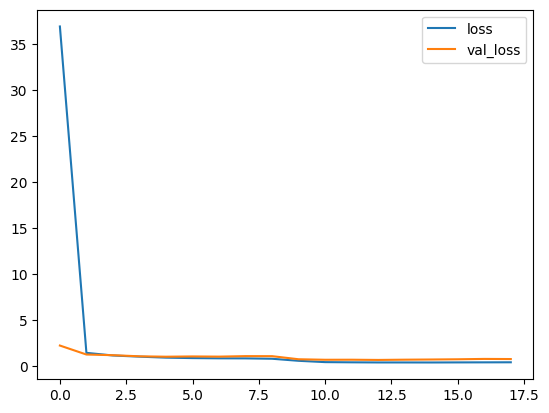

In [49]:
# Plot
plt.plot(loss, label = 'loss')
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.show()

In [68]:
# Predictions with test data
predictions = model.predict(X_test_array)

# Extracting the labels
predictions_labels = predictions.argmax(axis = 1)

# Metrics
print('Metrics')
print(classification_report(y_test_le, predictions_labels))

# Confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_test_le, predictions_labels))

# Accuracy
print('Accuracy')
print(accuracy_score(y_test_le, predictions_labels))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Metrics
              precision    recall  f1-score   support

           0       0.88      0.81      0.85       275
           1       0.84      0.84      0.84       224
           2       0.89      0.89      0.89       695
           3       0.67      0.72      0.70       159
           4       0.88      0.89      0.88       581
           5       0.69      0.67      0.68        66

    accuracy                           0.85      2000
   macro avg       0.81      0.80      0.80      2000
weighted avg       0.85      0.85      0.85      2000

Confusion Matrix
[[224  10  12   2  25   2]
 [  3 189   3   0  21   8]
 [  8   5 616  42  16   8]
 [  1   2  32 115   8   1]
 [ 18   9  26  10 517   1]
 [  1  11   6   2   2  44]]
Accuracy
0.8525


In [70]:
# Saving the model
model.save('models/model_v1.keras')

---

## 8) Loading model

In [72]:
# Loading the model
loaded_model = tf.keras.models.load_model('models/model_v1.keras')

# New sentence
frase = 'I am distressed because my girlfriend is sick'

# Creating a dataframe with the sentence
df_new = pd.DataFrame({'text': [frase]})

# Applying processing function
df_new['transformed_text'] = df_new['text'].apply(data_preprocessing)

df_new.head()

,text,transformed_text
0,I am distressed because my girlfriend is sick,distressed girlfriend sick


In [76]:
# Vectorizing
df_new_tfidf = tf_idf.transform(df_new['transformed_text'])

# To array
df_new_array = df_new_tfidf.toarray()

# Previsões
prediction = loaded_model.predict(df_new_array)

# Seleciona a classe com maior probabilidade
class_prob = np.argmax(prediction, axis = 1)

# Obtém o nome da classe
class_label = le.inverse_transform(class_prob)

# Class predicted
print(f'The feeling is {class_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The feeling is ['fear']


## Fim